In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_excel(io.BytesIO(uploaded["Dry_Bean_Dataset.xlsx"]))

# Ä°lk 5 satÄ±rÄ± gÃ¶ster
print(df.head())

Saving Dry_Bean_Dataset.xlsx to Dry_Bean_Dataset.xlsx
    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3

In [67]:
# %5 eksik veri eklenecek sÃ¼tunlar
for col in ['Area', 'Perimeter']:
    df.loc[df.sample(frac=0.05, random_state=42).index, col] = np.nan

# %35 eksik veri eklenecek sÃ¼tun
df.loc[df.sample(frac=0.35, random_state=42).index, 'Eccentricity'] = np.nan

# Eksik deÄŸerlerin sayÄ±sÄ±
print(df.isnull().sum())

Area                681
Perimeter           681
MajorAxisLength       0
MinorAxisLength       0
AspectRation          0
Eccentricity       4764
ConvexArea            0
EquivDiameter         0
Extent                0
Solidity              0
roundness             0
Compactness           0
ShapeFactor1          0
ShapeFactor2          0
ShapeFactor3          0
ShapeFactor4          0
Class                 0
dtype: int64


In [68]:
# 'Area' ve 'Perimeter' sÃ¼tunlarÄ±nÄ± ortalama ile dolduralÄ±m
df['Area'].fillna(df['Area'].mean(), inplace=True)
df['Perimeter'].fillna(df['Perimeter'].mean(), inplace=True)


#df.fillna({col: 'Area'}, inplace=True)
#df.fillna({col: 'Perimeter'}, inplace=True)


<ipython-input-68-8eb3ff45daa9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Area'].fillna(df['Area'].mean(), inplace=True)
<ipython-input-68-8eb3ff45daa9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [69]:
df.drop(columns=['Eccentricity'], inplace=True)

In [70]:
print(df.isnull().sum())
print(df.shape)           # Veri setinin son hali

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64
(13611, 16)


In [71]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(df[numeric_columns]))
outliers = (z_scores > 3)
print("AykÄ±rÄ± deÄŸer sayÄ±sÄ± (toplam hÃ¼cre):", outliers.sum().sum())

AykÄ±rÄ± deÄŸer sayÄ±sÄ± (toplam hÃ¼cre): 3409


In [72]:
# TÃ¼m aykÄ±rÄ± deÄŸer iÃ§eren satÄ±rlarÄ± silelim
df_clean = df[(z_scores < 3).all(axis=1)]

print("Yeni veri seti boyutu:", df_clean.shape)

Yeni veri seti boyutu: (12601, 16)


In [73]:
features = df_clean.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df_scaled = df_clean.copy()
df_scaled[features] = scaler.fit_transform(df_clean[features])
print(df_scaled.head())

       Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0 -1.219771  -1.379233        -1.494873        -0.727947     -1.545888   
2 -1.159047  -1.289524        -1.424534        -0.658533     -1.494216   
3 -1.120332  -1.148174        -1.458858        -0.434717     -1.725621   
5 -1.103625  -1.219304        -1.428553        -0.468919     -1.653697   
6 -1.091419  -0.991406        -1.451410        -0.382970     -1.753971   

   ConvexArea  EquivDiameter    Extent  Solidity  roundness  Compactness  \
0   -1.175004      -1.302189  0.277321  0.348921   1.419271     1.808079   
2   -1.117223      -1.222499  0.584547  0.546120   1.239599     1.733102   
3   -1.055946      -1.172387  0.683443 -3.063248   0.464374     2.052976   
5   -1.063294      -1.150925  0.532051  0.532379   1.169025     1.977682   
6   -1.041367      -1.135304  0.244391 -0.990840  -0.433427     2.135498   

   ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0      0.666365      2.396131  

In [74]:
label_encoder = LabelEncoder()
df_scaled['Class'] = label_encoder.fit_transform(df_scaled['Class'])
print("SÄ±nÄ±f etiketleri:", list(label_encoder.classes_))
print(df_scaled['Class'].value_counts())

SÄ±nÄ±f etiketleri: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
Class
3    3520
6    2623
5    2011
4    1632
2    1544
0    1262
1       9
Name: count, dtype: int64


In [75]:
X = df_scaled.drop(columns=['Class'])
y = df_scaled['Class']
pca = PCA()
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print("AÃ§Ä±klanan varyans oranlarÄ±:", explained_variance)

AÃ§Ä±klanan varyans oranlarÄ±: [6.05636914e-01 2.16915824e-01 7.07359442e-02 5.65899623e-02
 3.19311256e-02 6.72900955e-03 6.27986386e-03 2.77800305e-03
 1.99008620e-03 3.19105991e-04 7.66263590e-05 1.12884571e-05
 5.43437009e-06 6.74744427e-07 1.36741178e-07]


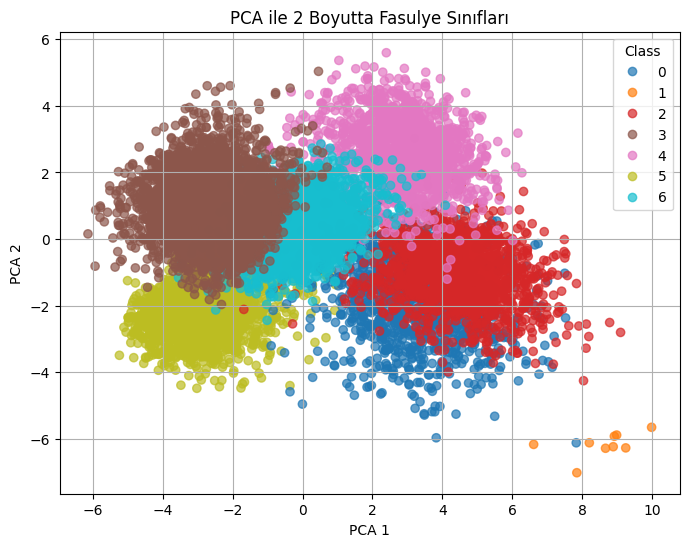

In [76]:
# Ä°lk 2 bileÅŸeni al
pca2 = PCA(n_components=2)
X_pca_2d = pca2.fit_transform(X)

# 2D GÃ¶rselleÅŸtirme
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA ile 2 Boyutta Fasulye SÄ±nÄ±flarÄ±")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()

In [77]:
# LDA nesnesi oluÅŸtur (3 bileÅŸen istiyoruz)
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X, y)
print("LDA ile elde edilen bileÅŸenlerin ÅŸekli:", X_lda.shape)

LDA ile elde edilen bileÅŸenlerin ÅŸekli: (12601, 3)


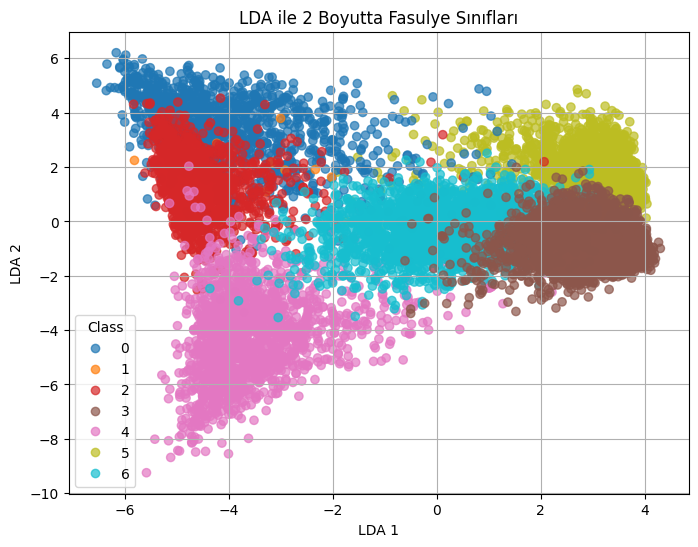

In [78]:
# 2 boyutlu grafik (ilk 2 bileÅŸen)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.title("LDA ile 2 Boyutta Fasulye SÄ±nÄ±flarÄ±")
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()

In [79]:
def evaluate_model(model, param_grid, X, y):
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_

        y_pred = best_model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='macro'))
        rec_scores.append(recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))

    return {
        'accuracy': (np.mean(acc_scores), np.std(acc_scores)),
        'precision': (np.mean(prec_scores), np.std(prec_scores)),
        'recall': (np.mean(rec_scores), np.std(rec_scores)),
        'f1': (np.mean(f1_scores), np.std(f1_scores))
    }

In [80]:
# Ham veri (Ã¶lÃ§eklenmiÅŸ ve ayÄ±klanmÄ±ÅŸ haliyle)
X_raw = df_scaled.drop(columns=['Class']).values
y_raw = df_scaled['Class'].values

# Parametre aralÄ±ÄŸÄ± (grid search iÃ§in)
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}


logreg_results = evaluate_model(LogisticRegression(max_iter=1000), logreg_params, X_raw, y_raw)
for metric, (mean, std) in logreg_results.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

Accuracy: 0.9182 Â± 0.0046
Precision: 0.9369 Â± 0.0035
Recall: 0.9331 Â± 0.0034
F1: 0.9347 Â± 0.0033


In [81]:
pca_final = PCA(n_components=0.95)
X_pca = pca_final.fit_transform(X_raw)
print("PCA veri ÅŸekli:", X_pca.shape)

PCA veri ÅŸekli: (12601, 5)


In [82]:
logreg_results_pca = evaluate_model(LogisticRegression(max_iter=1000), logreg_params, X_pca, y_raw)

print("\nðŸ“Š PCA Temsili ile Logistic Regression:")
for metric, (mean, std) in logreg_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


ðŸ“Š PCA Temsili ile Logistic Regression:
Accuracy: 0.9028 Â± 0.0032
Precision: 0.7800 Â± 0.0023
Recall: 0.7755 Â± 0.0031
F1: 0.7775 Â± 0.0023


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [83]:
lda_final = LDA(n_components=3)
X_lda = lda_final.fit_transform(X_raw, y_raw)

print("LDA veri ÅŸekli:", X_lda.shape)


LDA veri ÅŸekli: (12601, 3)


In [84]:
logreg_results_lda = evaluate_model(LogisticRegression(max_iter=1000), logreg_params, X_lda, y_raw)

print("\nðŸ“Š LDA Temsili ile Logistic Regression:")
for metric, (mean, std) in logreg_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


ðŸ“Š LDA Temsili ile Logistic Regression:
Accuracy: 0.8870 Â± 0.0049
Precision: 0.7628 Â± 0.0042
Recall: 0.7535 Â± 0.0053
F1: 0.7571 Â± 0.0046


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

In [86]:
tree_results_raw = evaluate_model(DecisionTreeClassifier(random_state=42), tree_params, X_raw, y_raw)

print("\nðŸŒ¿ Decision Tree â€“ Ham Veri:")
for metric, (mean, std) in tree_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



ðŸŒ¿ Decision Tree â€“ Ham Veri:
Accuracy: 0.9018 Â± 0.0024
Precision: 0.8697 Â± 0.0548
Recall: 0.8625 Â± 0.0547
F1: 0.8626 Â± 0.0499


In [87]:
tree_results_pca = evaluate_model(DecisionTreeClassifier(random_state=42), tree_params, X_pca, y_raw)

print("\nðŸŒ¿ Decision Tree â€“ PCA:")
for metric, (mean, std) in tree_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



ðŸŒ¿ Decision Tree â€“ PCA:
Accuracy: 0.8918 Â± 0.0030
Precision: 0.8128 Â± 0.0566
Recall: 0.8087 Â± 0.0584
F1: 0.8100 Â± 0.0580


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [88]:
tree_results_lda = evaluate_model(DecisionTreeClassifier(random_state=42), tree_params, X_lda, y_raw)

print("\nðŸŒ¿ Decision Tree â€“ LDA:")
for metric, (mean, std) in tree_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


ðŸŒ¿ Decision Tree â€“ LDA:
Accuracy: 0.8794 Â± 0.0039
Precision: 0.7522 Â± 0.0053
Recall: 0.7499 Â± 0.0034
F1: 0.7501 Â± 0.0041


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [89]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

In [90]:
rf_results_raw = evaluate_model(RandomForestClassifier(random_state=42), rf_params, X_raw, y_raw)

print("\nðŸŒ² Random Forest â€“ Ham Veri:")
for metric, (mean, std) in rf_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")


ðŸŒ² Random Forest â€“ Ham Veri:
Accuracy: 0.9206 Â± 0.0072
Precision: 0.9378 Â± 0.0050
Recall: 0.9187 Â± 0.0332
F1: 0.9256 Â± 0.0235


In [91]:
rf_results_pca = evaluate_model(RandomForestClassifier(random_state=42), rf_params, X_pca, y_raw)

print("\nðŸŒ² Random Forest â€“ PCA:")
for metric, (mean, std) in rf_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")


ðŸŒ² Random Forest â€“ PCA:
Accuracy: 0.9191 Â± 0.0039
Precision: 0.9367 Â± 0.0028
Recall: 0.9332 Â± 0.0028
F1: 0.9347 Â± 0.0027


In [92]:
rf_results_lda = evaluate_model(RandomForestClassifier(random_state=42), rf_params, X_lda, y_raw)

print("\nðŸŒ² Random Forest â€“ LDA:")
for metric, (mean, std) in rf_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



ðŸŒ² Random Forest â€“ LDA:
Accuracy: 0.8998 Â± 0.0054
Precision: 0.8713 Â± 0.0594
Recall: 0.8520 Â± 0.0558
F1: 0.8590 Â± 0.0554


In [93]:
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01]
}

In [94]:
xgb_results_raw = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                                 xgb_params, X_raw, y_raw)

print("\nâš¡ XGBoost â€“ Ham Veri:")
for metric, (mean, std) in xgb_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:39:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:39:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost


âš¡ XGBoost â€“ Ham Veri:
Accuracy: 0.9257 Â± 0.0062
Precision: 0.9143 Â± 0.0590
Recall: 0.8824 Â± 0.0565
F1: 0.8935 Â± 0.0549


In [95]:
xgb_results_pca = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                                 xgb_params, X_pca, y_raw)

print("\nâš¡ XGBoost â€“ PCA:")
for metric, (mean, std) in xgb_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


âš¡ XGBoost â€“ PCA:
Accuracy: 0.9187 Â± 0.0048
Precision: 0.9268 Â± 0.0171
Recall: 0.9177 Â± 0.0315
F1: 0.9188 Â± 0.0214


In [96]:
xgb_results_lda = evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                                 xgb_params, X_lda, y_raw)

print("\nâš¡ XGBoost â€“ LDA:")
for metric, (mean, std) in xgb_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn


âš¡ XGBoost â€“ LDA:
Accuracy: 0.8986 Â± 0.0038
Precision: 0.8269 Â± 0.0588
Recall: 0.8224 Â± 0.0561
F1: 0.8206 Â± 0.0506


In [97]:
nb_results_raw = evaluate_model(GaussianNB(), {}, X_raw, y_raw)

print("\nðŸ“¦ Naive Bayes â€“ Ham Veri:")
for metric, (mean, std) in nb_results_raw.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")


ðŸ“¦ Naive Bayes â€“ Ham Veri:
Accuracy: 0.8953 Â± 0.0052
Precision: 0.9016 Â± 0.0189
Recall: 0.8963 Â± 0.0290
F1: 0.8951 Â± 0.0198


In [98]:
nb_results_pca = evaluate_model(GaussianNB(), {}, X_pca, y_raw)

print("\nðŸ“¦ Naive Bayes â€“ PCA:")
for metric, (mean, std) in nb_results_pca.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")


ðŸ“¦ Naive Bayes â€“ PCA:
Accuracy: 0.9004 Â± 0.0044
Precision: 0.9099 Â± 0.0179
Recall: 0.9204 Â± 0.0047
F1: 0.9138 Â± 0.0104


In [99]:
nb_results_lda = evaluate_model(GaussianNB(), {}, X_lda, y_raw)

print("\nðŸ“¦ Naive Bayes â€“ LDA:")
for metric, (mean, std) in nb_results_lda.items():
    print(f"{metric.title()}: {mean:.4f} Â± {std:.4f}")


ðŸ“¦ Naive Bayes â€“ LDA:
Accuracy: 0.8931 Â± 0.0027
Precision: 0.8845 Â± 0.0265
Recall: 0.9026 Â± 0.0041
F1: 0.8892 Â± 0.0165


In [100]:
results_summary = {
    ('LogReg', 'Raw'): logreg_results,
    ('LogReg', 'PCA'): logreg_results_pca,
    ('LogReg', 'LDA'): logreg_results_lda,

    ('Tree', 'Raw'): tree_results_raw,
    ('Tree', 'PCA'): tree_results_pca,
    ('Tree', 'LDA'): tree_results_lda,

    ('RF', 'Raw'): rf_results_raw,
    ('RF', 'PCA'): rf_results_pca,
    ('RF', 'LDA'): rf_results_lda,

    ('XGB', 'Raw'): xgb_results_raw,
    ('XGB', 'PCA'): xgb_results_pca,
    ('XGB', 'LDA'): xgb_results_lda,

    ('NB', 'Raw'): nb_results_raw,
    ('NB', 'PCA'): nb_results_pca,
    ('NB', 'LDA'): nb_results_lda
}

rows = []
for (model, version), metrics in results_summary.items():
    row = {
        'Model': model,
        'Veri Temsili': version,
        'Accuracy': f"{metrics['accuracy'][0]:.4f} Â± {metrics['accuracy'][1]:.4f}",
        'Precision': f"{metrics['precision'][0]:.4f} Â± {metrics['precision'][1]:.4f}",
        'Recall': f"{metrics['recall'][0]:.4f} Â± {metrics['recall'][1]:.4f}",
        'F1 Score': f"{metrics['f1'][0]:.4f} Â± {metrics['f1'][1]:.4f}",
    }
    rows.append(row)

df_results = pd.DataFrame(rows)
print(df_results)

     Model Veri Temsili         Accuracy        Precision           Recall  \
0   LogReg          Raw  0.9182 Â± 0.0046  0.9369 Â± 0.0035  0.9331 Â± 0.0034   
1   LogReg          PCA  0.9028 Â± 0.0032  0.7800 Â± 0.0023  0.7755 Â± 0.0031   
2   LogReg          LDA  0.8870 Â± 0.0049  0.7628 Â± 0.0042  0.7535 Â± 0.0053   
3     Tree          Raw  0.9018 Â± 0.0024  0.8697 Â± 0.0548  0.8625 Â± 0.0547   
4     Tree          PCA  0.8918 Â± 0.0030  0.8128 Â± 0.0566  0.8087 Â± 0.0584   
5     Tree          LDA  0.8794 Â± 0.0039  0.7522 Â± 0.0053  0.7499 Â± 0.0034   
6       RF          Raw  0.9206 Â± 0.0072  0.9378 Â± 0.0050  0.9187 Â± 0.0332   
7       RF          PCA  0.9191 Â± 0.0039  0.9367 Â± 0.0028  0.9332 Â± 0.0028   
8       RF          LDA  0.8998 Â± 0.0054  0.8713 Â± 0.0594  0.8520 Â± 0.0558   
9      XGB          Raw  0.9257 Â± 0.0062  0.9143 Â± 0.0590  0.8824 Â± 0.0565   
10     XGB          PCA  0.9187 Â± 0.0048  0.9268 Â± 0.0171  0.9177 Â± 0.0315   
11     XGB          LDA  0.8986

In [101]:
class_names = label_encoder.classes_.tolist()

In [102]:
def full_roc_auc_summary(models_dict, data_dict, y, class_names):
    all_results = []

    for model_name, model in models_dict.items():
        for rep_name, X in data_dict.items():

            y_bin = label_binarize(y, classes=np.unique(y))
            n_classes = y_bin.shape[1]

            model.fit(X, y)
            y_score = model.predict_proba(X)

            plt.figure(figsize=(8,6))
            plt.title(f"{model_name} â€“ {rep_name}")
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                all_results.append({
                    'Model': model_name,
                    'Veri Temsili': rep_name,
                    'SÄ±nÄ±f': class_names[i],
                    'ROC-AUC': roc_auc
                })
                plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

            plt.plot([0,1], [0,1], 'k--', lw=1)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(all_results)


In [103]:
models_dict = {
    "Logistic Regression": LogisticRegression(C=1, solver='liblinear', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=2, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Naive Bayes": GaussianNB()
}

data_dict = {
    "Ham Veri": X_raw,
    "PCA": X_pca,
    "LDA": X_lda
}


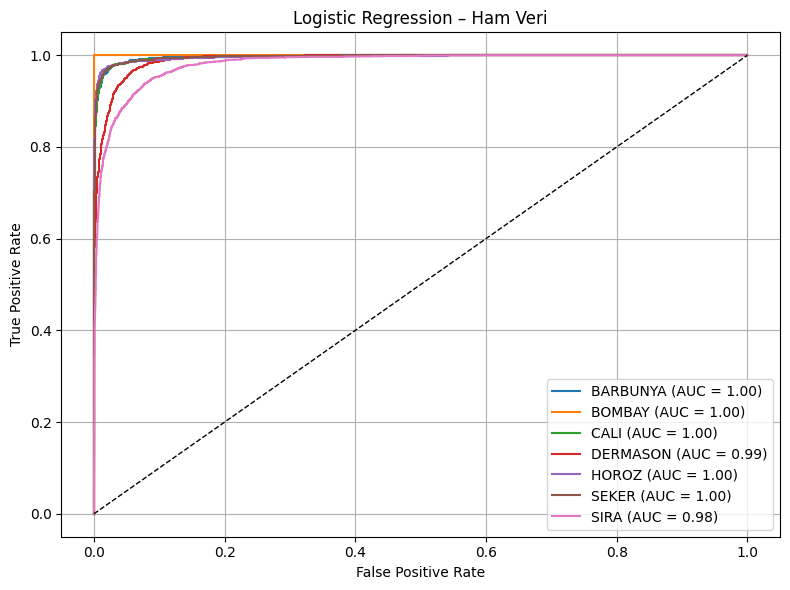

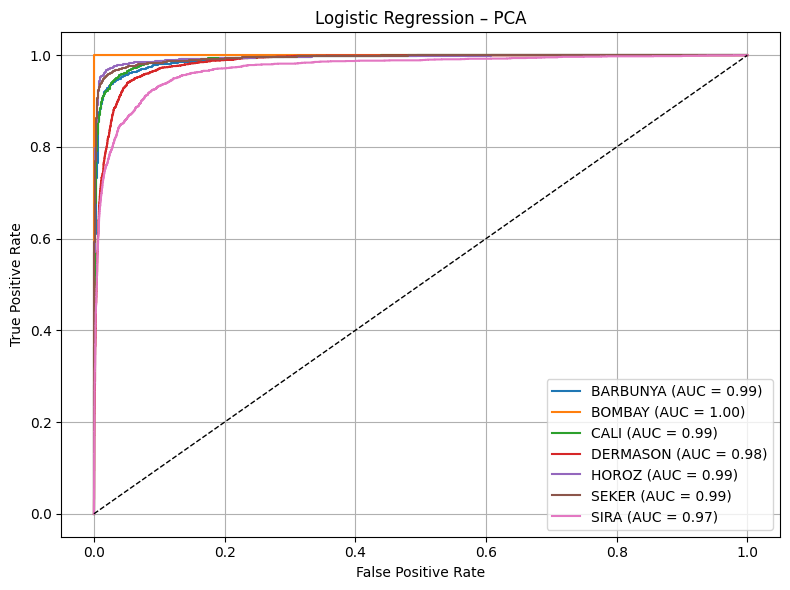

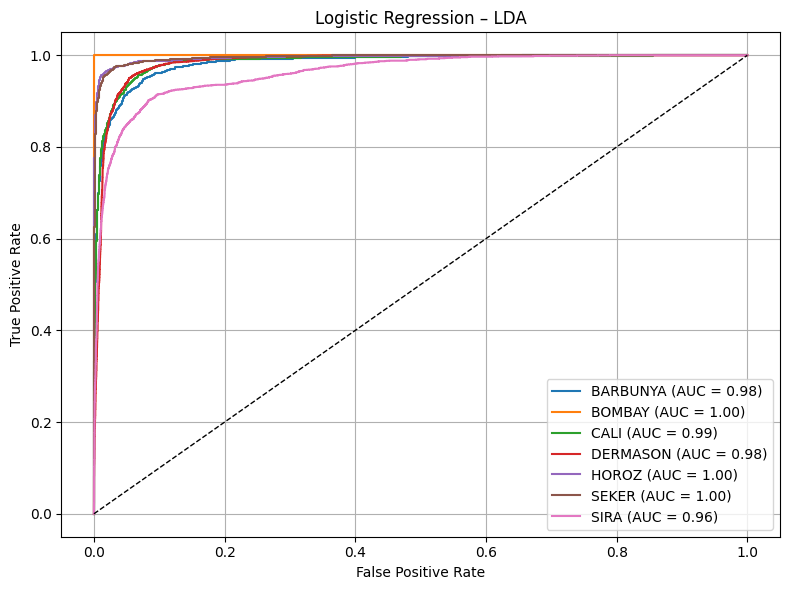

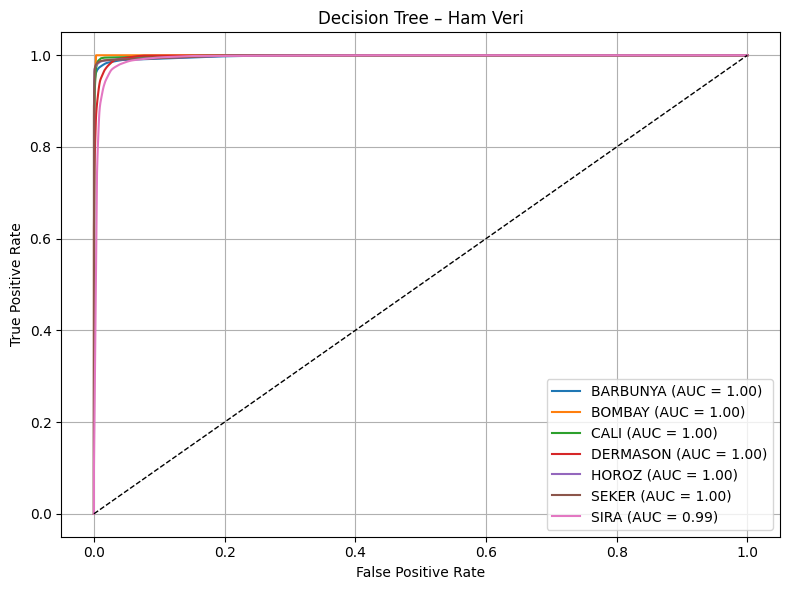

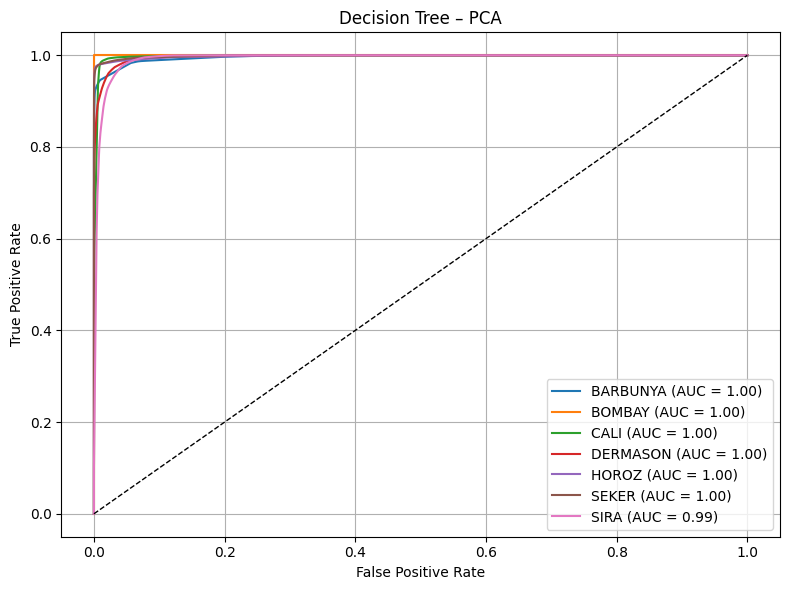

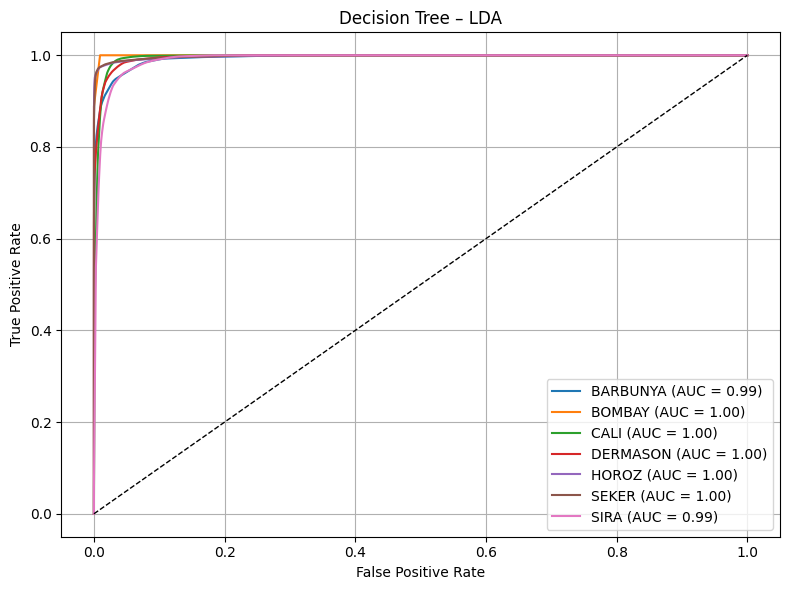

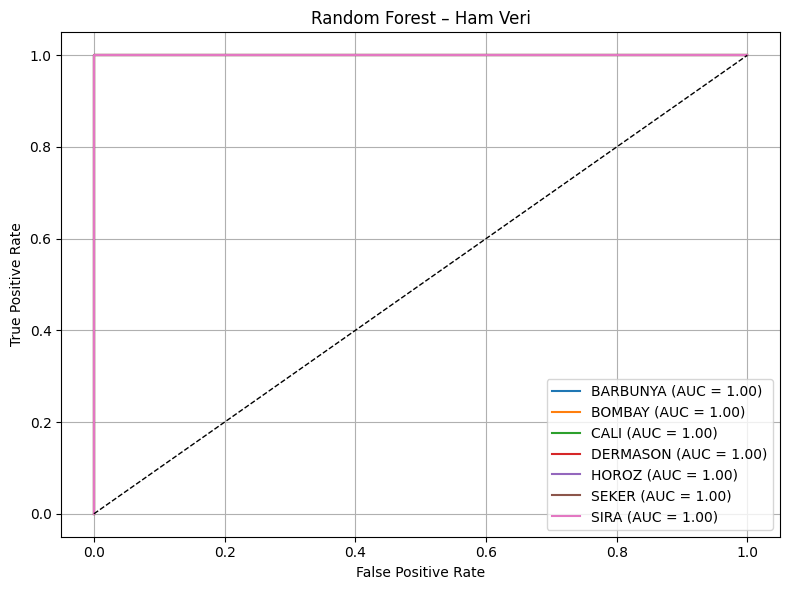

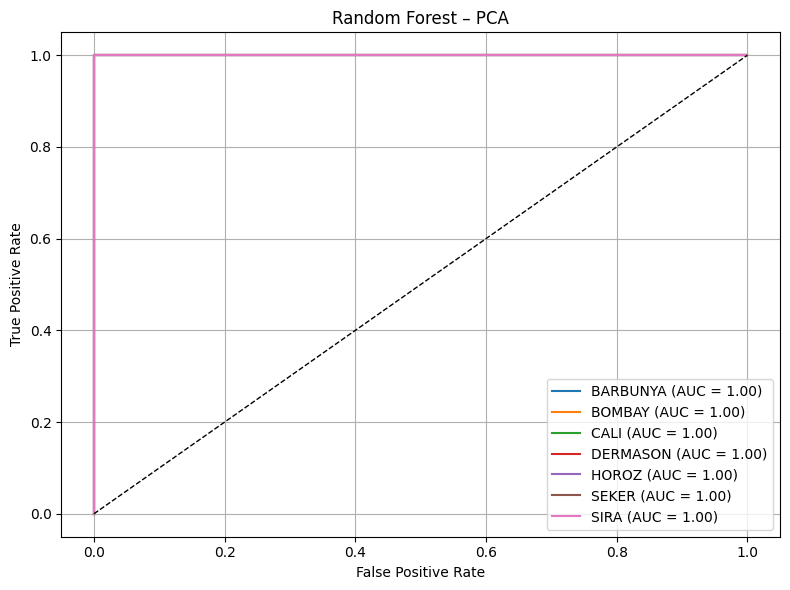

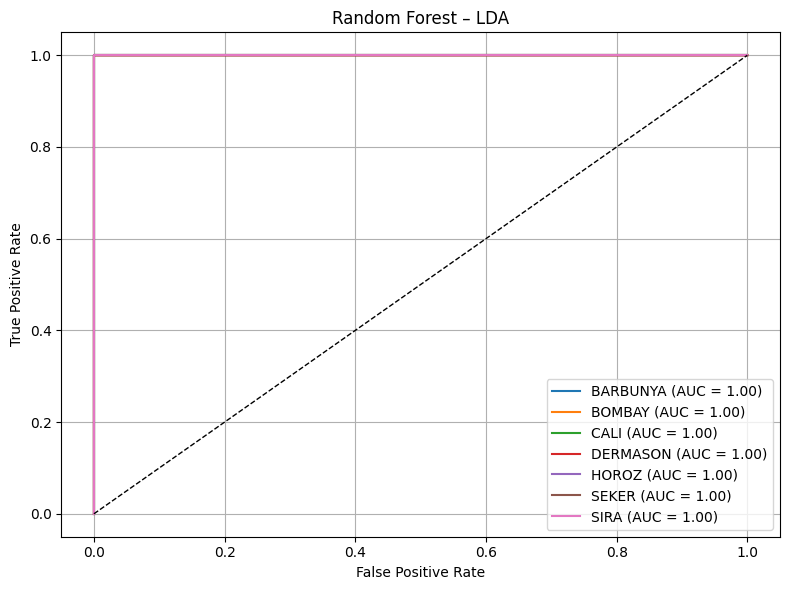

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


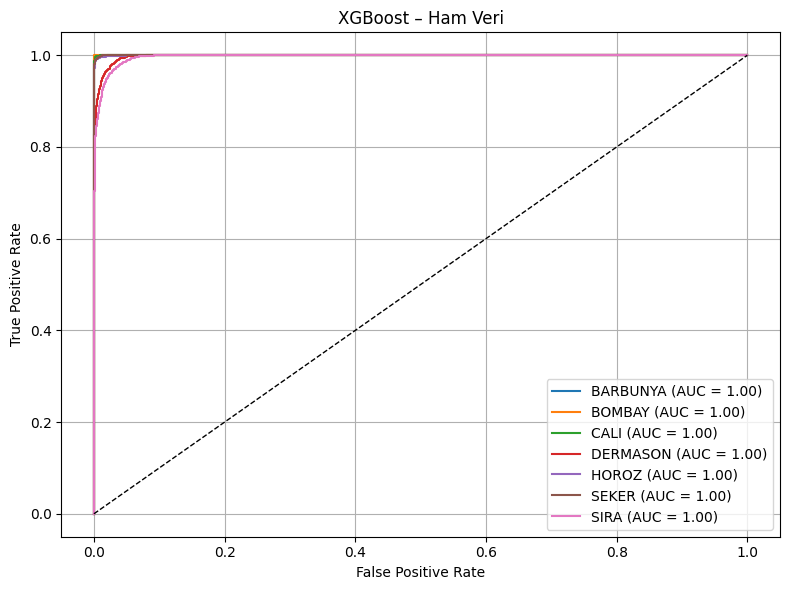

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


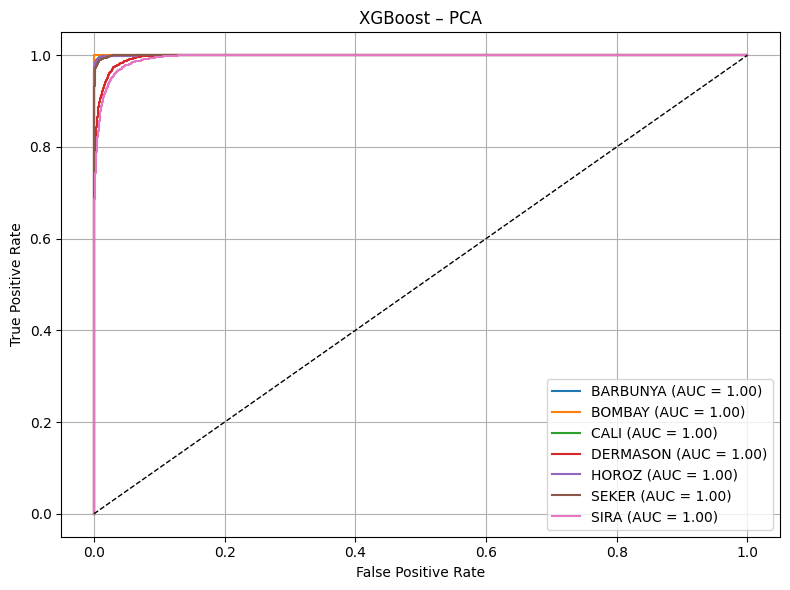

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:41:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


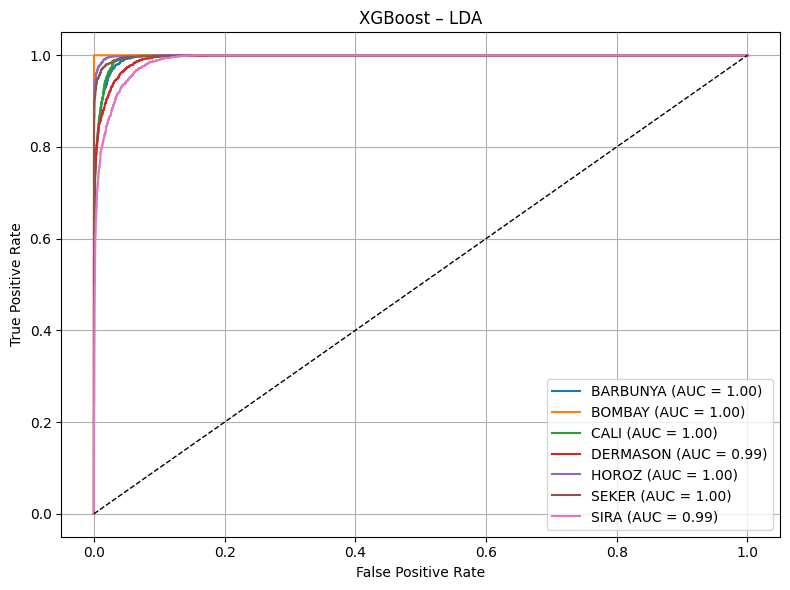

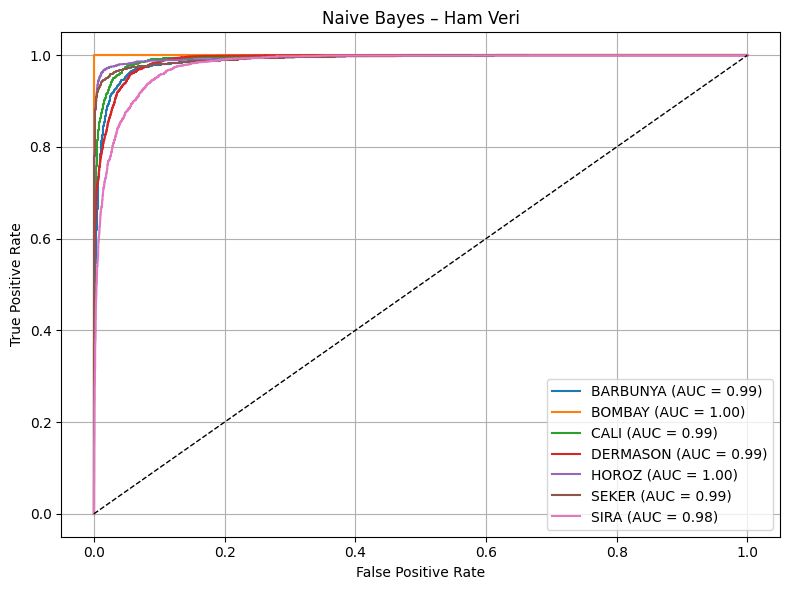

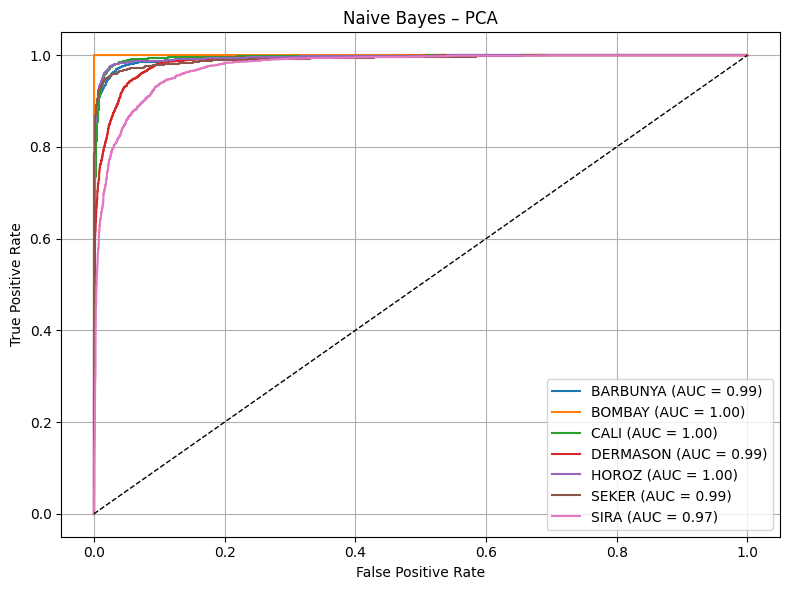

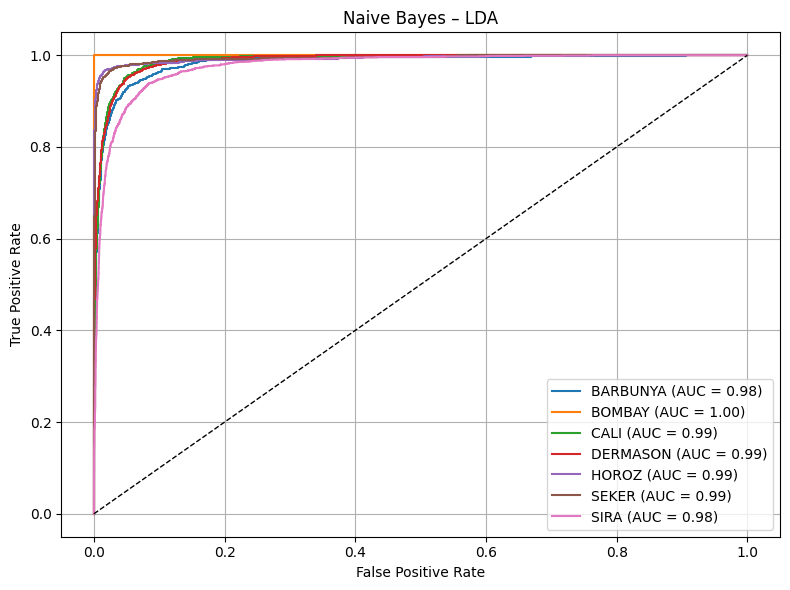

Veri Temsili         Ham Veri     LDA     PCA
Model                                        
Decision Tree          0.9979  0.9960  0.9972
Logistic Regression    0.9941  0.9866  0.9895
Naive Bayes            0.9916  0.9892  0.9912
Random Forest          1.0000  1.0000  1.0000
XGBoost                0.9992  0.9965  0.9987


In [104]:
auc_all_df = full_roc_auc_summary(models_dict, data_dict, y_raw, class_names)

summary_auc = auc_all_df.groupby(['Model', 'Veri Temsili'])['ROC-AUC'].mean().round(4).reset_index()
print(summary_auc.pivot(index='Model', columns='Veri Temsili', values='ROC-AUC'))
